# Deep Learning for the Physical Layer - Autoncoders

The goal of this notebook is to implement the autoencoder presented by [O'Shea and Hoydis, 2017](https://arxiv.org/pdf/1702.00832.pdf).

## Autoencoder with Pytorch

We use pytorch to implement the autoencoder presented in the paper

In [232]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math
# To make the plots
import matplotlib.pyplot as plt
%matplotlib inline
# To do block encoding (Hamming)
import sk_dsp_comm.fec_block as block
# To supress some strange output at runtime
from IPython.utils import io
# Used during plotting the training loss
from IPython import display
# To make plots about constellations
from sklearn.manifold import TSNE
import matplotlib.cm as cm

If possible we are going to use GPU to train faster

In [401]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Pytorch device: %s' % (device))

Pytorch device: cuda:0


In [402]:
def paper_normalization(x, n):
    """
    The paper defines a specific normalization.
    Implementing it here to be able to use it Encoder
    """
    # Doing the normalization to get the final result of the encoder
    normalization_term = math.sqrt(n)/torch.sum(torch.sqrt(x**2), dim=1)
    x = x*normalization_term.unsqueeze(1)
    
    return x

Implementing the encoder with pytorch

In [403]:
class Encoder(nn.Module):
    """
    This is going to be the definition of the encoder.
    """
    def __init__(self, m, n, embed_dim=512, use_embedding=True, use_paper_norm=False):
        """
        Initialization of the encoder
        
        Args:
          m (int): Transmitter can have up to M different messages. Each of this messages gets encoded
          n (int): Length of the encoding
        """
        super(Encoder, self).__init__()
        
        self.n = n
        
        """
        The encoder in the paper is implemented with Tensorflow
        Layers in Tensorflow:
          - Dense + ReLU. Out M
              - Alternatively also use Embedding
          - Dense + linear. Out n
          - Normalization (some normalization defined by the paper) Out n
        Layers equivalent in Pytorch:
          - Linear + ReLU. Out M
              - Alternatively also use Embedding
          - Linear + (nothing). Out n
          - Normalization (some normalization defined by the paper). Is gonna be done in forward function. Out n
        """

        if use_embedding:
            self.linear_M = nn.Sequential(
                nn.Embedding(num_embeddings=m, embedding_dim=embed_dim),
                nn.Linear(in_features=embed_dim, out_features=m),
                nn.ReLU(),
            )
        else:
            self.linear_M = nn.Sequential(
                nn.Linear(in_features=m, out_features=m),
                nn.ReLU(),
            )
        
        self.linear_N = nn.Sequential(
            nn.Linear(in_features=m, out_features=n),
        )
        
        if use_paper_norm:
            self.normalization = paper_normalization
        else:
            self.normalization = nn.BatchNorm1d(num_features=n)
        
        self.init_weights()
    
    def init_weights(self):
        """
        Function to initialize the weights and bias of the linear layers
        """
        for m in self.modules():
            if type(m) is torch.nn.Linear:
                torch.nn.init.normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
        
    def forward(self, x):
        """
        Forward pass over x
        
        Args:
          x of shape (batch_size, m): Messages that pass through the autoencoder
        
        Returns:
          y of shape (batch_size, n): Messages after encoding+noise+decoding
        """
        x = self.linear_M(x)
        x = self.linear_N(x.squeeze())
        y = self.normalization(x)
        
        return y

In [404]:
class Decoder(nn.Module):
    """
    This is going to be the definition of the decoder.
    """
    def __init__(self, m, n):
        """
        Initialization of the decoder
        
        Args:
          m (int): Transmitter can have up to M different messages. Each of this messages gets encoded
          n (int): Length of the encoding
        """
        super(Decoder, self).__init__()
        
        """
        The decoder in the paper is implemented with Tensorflow
        Layers in Tensorflow:
          - Dense + ReLU. Out M
          - Dense + Softmax. Out M
        Layers equivalent in Pytorch:
          - Linear + ReLU. Out M
          - Linear + (ommited). Out M
          Softmax is going to be ommited to use pytorch loss function CrossEntropyLoss
          CrossEntropyLoss combines LogSoftmax and NLLLoss (Negative Log Likelihood) in one single class.
        """
        self.linear_relu = nn.Sequential(
            nn.Linear(in_features=n, out_features=m),
            nn.ReLU(),
        )
        
        self.linear_out = nn.Sequential(
            nn.Linear(in_features=m, out_features=m),
        )
        
        self.init_weights()
        
    def init_weights(self):
        """
        Function to initialize the weights and bias of the linear layers
        """
        for m in self.modules():
            if type(m) is torch.nn.Linear:
                torch.nn.init.normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
        
    def forward(self, y):
        """
        Forward pass over y
        
        Args:
          y of shape (batch_size, n): Messages that that pass through the autoencoder
        
        Returns:
          y of shape (batch_size, M): Messages after encoding+noise+decoding
        """
        # Decoding phase
        y = self.linear_relu(y)
        y = self.linear_out(y)
        
        return y

In [405]:
def channel(x, n, k, snr_db):
    """
    Definition of the channel. e.g. Add AWGN to the samples
    Args:
        x of shape (batch_size, k): Encoded messages
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        snr_db (float): SNR to add noise
        
    Returns:
        x_channel of shape (batch_size, k): x with npose
    """
    # Transform from dB to linear
    snr_lin = 10**(snr_db/10)
    # Get the rate of the encoding
    rate = k/n
    # Finally calculate the variance of the AWGN
    n0 = 1/(snr_lin*rate)
    var_channel = math.sqrt(n0/2)
    
    # Use the reparametrization trick to apply noise to x
    if torch.is_tensor(x):
        x_channel = x + var_channel*torch.randn_like(x)
    else:
        x_channel = x + var_channel*np.random.randn(*x.shape)
    
    return x_channel

In [413]:
def train_autoencoder(n, k, snr_db=7, use_embedding=False, use_paper_norm=False,
                      n_epochs=1000, lr=0.001, clipping=None, plot=True):
    # Original messages has k bits. Meaning it can have until 2**k different messages
    m = 2**k
    # Initialize the encoder and decoder
    encoder = Encoder(m=m, n=n, use_embedding=use_embedding, use_paper_norm=use_paper_norm)
    encoder.to(device)
    decoder = Decoder(m=m, n=n)
    decoder.to(device)
    
    # Adam optimizer for both encoder and decoder
    enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
    dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

    # To keep track of losses during training
    losses = []
    avg_losses = []
    for epoch in range(n_epochs):
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # If we are using embedding the input must be an integer with the id of the message to transmit
        # e.g. [0, 1, 2, 3, ...]
        # If we are not using embedding then the inputs are one hot vectors
        # e.g. message 1 = [1 0 0 0 0 0 ..]
        # messsage 2 = [0 1 0 0 0 0 ...]
        if use_embedding:
            data = torch.arange(0, m).to(device)
            data = data.unsqueeze(1)
        else:
            # Identity matrix for the one hot vectors
            data = torch.eye(m).to(device)

        # Encode the data
        encoded_data = encoder(data)
        
        # Sometimes during training the weights of the linear layers get NaN
        # This will cause wrong training. Trying to catch this mistakes
        if torch.isnan(encoded_data).any():
            print("Encoder went to nan. Epoch: %d" % (epoch))
        
        # Pass the encoded message through the channel
        data_channel = channel(encoded_data, n, k, snr_db)
        
        if torch.isnan(data_channel).any():
            print("Channel went to nan. Epoch: %d" % (epoch))
        
        # Decode the message
        decoded_data = decoder(data_channel)
        
        if torch.isnan(decoded_data).any():
            print("Decoder went to nan. Epoch: %d" % (epoch))

        # Cross entropy receives the correct labels for the original messages
        targets = torch.arange(0, m).to(device)
        loss = F.cross_entropy(decoded_data, targets)

        loss.backward()

        # Trying to avoid NaN in linear layers by clipping the gradients
        if clipping is not None:
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), clipping)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), clipping)

        enc_optimizer.step()
        dec_optimizer.step()
        
        # To keep track of training
        losses.append(loss.detach().to("cpu").numpy())
        if epoch > 1000:
            avg = np.mean(losses[-1000:])
        else:
            avg = np.mean(losses)
        avg_losses.append(avg)
        
        # Make a plot of training
        if (epoch%1000==0 and epoch != 0) and plot:
            plt.clf()
            plt.plot(losses)
            plt.plot(avg_losses)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Epoch: %d. Last avg loss: %f" % (epoch, avg_losses[-1]))
    if plot: print("Last avg loss: %f" % (avg_losses[-1]))
    
    return encoder, decoder, avg_losses

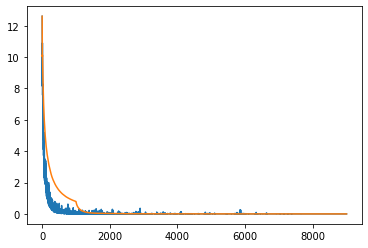

Epoch: 9000. Last avg loss: 0.000087
Last avg loss: 0.000144


(Encoder(
   (linear_M): Sequential(
     (0): Embedding(16, 512)
     (1): Linear(in_features=512, out_features=16, bias=True)
     (2): ReLU()
   )
   (linear_N): Sequential(
     (0): Linear(in_features=16, out_features=7, bias=True)
   )
   (normalization): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Decoder(
   (linear_relu): Sequential(
     (0): Linear(in_features=7, out_features=16, bias=True)
     (1): ReLU()
   )
   (linear_out): Sequential(
     (0): Linear(in_features=16, out_features=16, bias=True)
   )
 ))

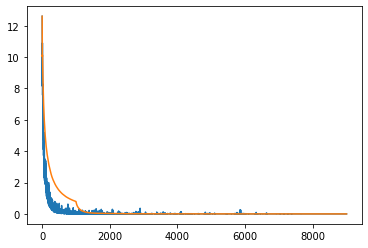

In [411]:
# Sample on how training can be executed
train_autoencoder(n=7, k=4, snr_db=7, n_epochs=10000, use_embedding=True, use_paper_norm=False)

In [415]:
hamming_sizes = [(4, 4), (7, 4), (8, 8), (2, 2)]
# Train over all the (n, k)
for n, k in hamming_sizes:
    print("Training autoencoder (%d, %d)" % (n, k))
    encoder, decoder, avg_losses = train_autoencoder(n=n, k=k, snr_db=7, n_epochs=10000,
                                                     use_embedding=True, plot=False, use_paper_norm=False)
    
    # Save the encoder and decoder models
    enc_filename = "%d_%d_encoder.pth" % (n, k)
    dec_filename = "%d_%d_decoder.pth" % (n, k)
    torch.save(encoder.state_dict(), enc_filename)
    torch.save(decoder.state_dict(), dec_filename)

    print("Finished training autoencoder (%d, %d). Last 1000 avg loss: %f" % (n, k, avg_losses[-1]))
    print("Models saved in %s, %s" % (enc_filename, dec_filename))

Training autoencoder (4, 4)
Finished training autoencoder (4, 4). Last 1000 avg loss: 0.000253
Models saved in 4_4_encoder.pth, 4_4_decoder.pth
Training autoencoder (7, 4)
Finished training autoencoder (7, 4). Last 1000 avg loss: 0.000135
Models saved in 7_4_encoder.pth, 7_4_decoder.pth
Training autoencoder (8, 8)
Finished training autoencoder (8, 8). Last 1000 avg loss: 0.003144
Models saved in 8_8_encoder.pth, 8_8_decoder.pth
Training autoencoder (2, 2)
Finished training autoencoder (2, 2). Last 1000 avg loss: 0.000129
Models saved in 2_2_encoder.pth, 2_2_decoder.pth


In [416]:
def recover_autoencoder(n, k, device, verbose=False):
    """
    Function to try to recover an already saved autoencoder
    Args:
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        device (string): Current device that we are working in
        
    Returns:
        x_channel of shape (batch_size, k): x with npose
    """
    try:
        m = 2**k
        enc_filename = "%d_%d_encoder.pth" % (n, k)
        dec_filename = "%d_%d_decoder.pth" % (n, k)
        
        encoder = Encoder(m=m, n=n)
        encoder.load_state_dict(torch.load(enc_filename))
        if verbose: print('Model loaded from %s.' % enc_filename)
        # Put them in the correct device and eval mode
        encoder.to(device)
        encoder.eval()
        
        decoder = Decoder(m=m, n=n)
        decoder.load_state_dict(torch.load(dec_filename))
        if verbose: print('Model loaded from %s.' % dec_filename)
        decoder.to(device)
        decoder.eval()
        
        return encoder, decoder
    except:
        raise("Something went wrong loading file for autoencoder (%d, %d)" % (n, k))

In [419]:
def plot_constellation(n, k, ax, snr_db=7, samples=20, use_embedding=True):
    """
    Function to plot a constellation with an already trained autoencoder
    Args:
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        ax (matplotlib object): Plotting in a subplot. Received subplot object
        snr_db (float): Noise to add to the encoded messages
        samples (int): Number of samples to plot
    Returns:
        ax (matplotlib object): Plot completed
    """
    # Recovering autoencoder
    encoder, _ = recover_autoencoder(n=n, k=k, device=device)
    m = 2**k
    # Getting the correct kind of inputs
    with torch.no_grad():
        if use_embedding:
            data = torch.arange(0, m).to(device)
            data = data.unsqueeze(1)
        else:
            data = torch.eye(m).to(device)
        encoded_data = encoder(data)
    
    # Pass from pytorch to numpy
    encoded_numpy = encoded_data.to("cpu").numpy()

    # We have m different messages
    classes = np.arange(m)
    
    # To store the results of each sample
    results_noise = np.zeros((1, n))
    labels = np.zeros(1)
    for i in range(samples):
        # Pass the encoded messages through noise
        noise_encode = channel(encoded_numpy, n, k, snr_db)
        # Add the samples to the array
        results_noise = np.concatenate((results_noise, noise_encode), axis=0)
        labels = np.concatenate((labels, classes))
    # The first row was a dummy to use concatenate. Removing it
    results_noise = results_noise[1:]
    labels = labels[1:]

    # Getting a 2 dimensional embedding for the points
    x_constellation = TSNE(n_components=2).fit_transform(results_noise)

    # Generating as many colors as neededd
    colors = cm.rainbow(np.linspace(0, 1, len(classes)))
    # Positiotioning the subplot
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height], which='both')
    # Plotting each different message
    for i in classes:
        ix = labels == i
        ax.plot(x_constellation[ix, 0], x_constellation[ix, 1], '.', color=colors[i])
#     plt.legend(classes, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_title("Constellation of autoencoder (%d, %d)" % (n, k))

    return ax    

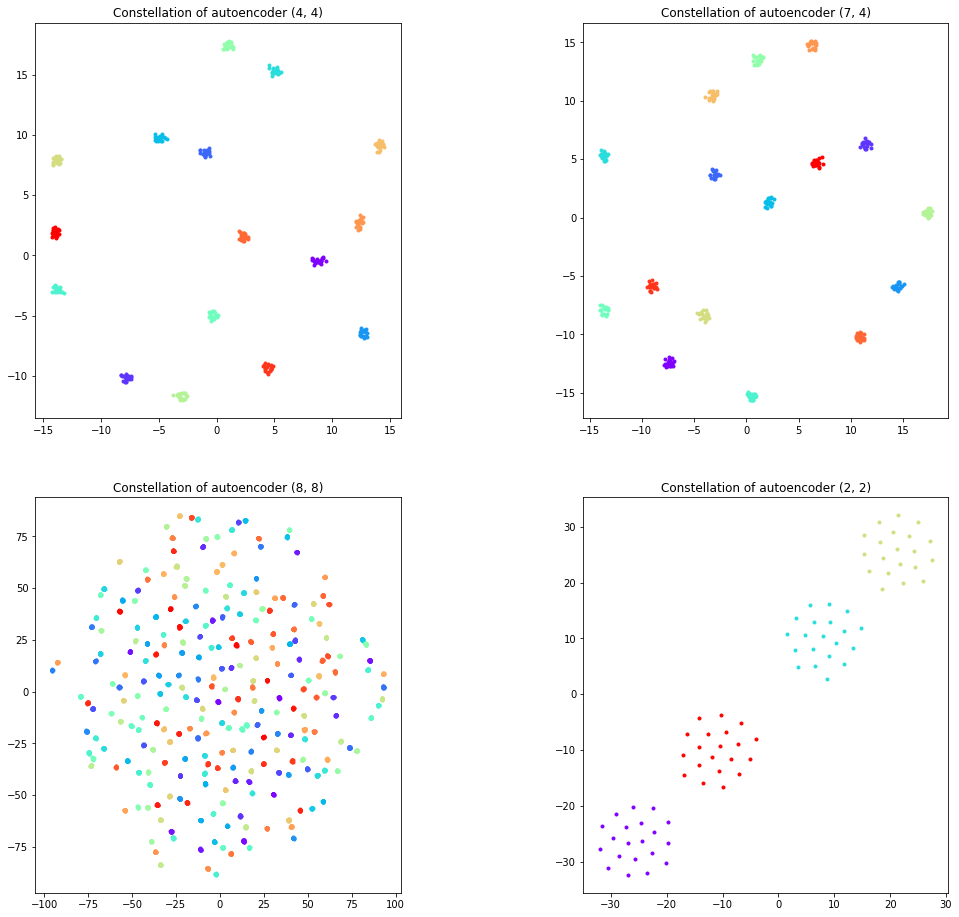

In [422]:
# Plot all (n, k)
hamming_sizes = [(4, 4), (7, 4), (8, 8), (2, 2)]
fig, axs = plt.subplots(2, 2, figsize=(18, 16), facecolor='w')
for i in range(2):
    for j in range(2):
        idx = j + i*2
        n, k = hamming_sizes[idx]
        ax = plot_constellation(n, k, axs[i, j])

In [423]:
def autoencoder_communication(n, k, snr_db, n_blocks, use_embedding=True, verbose=False):
    encoder, decoder = recover_autoencoder(n=n, k=k, device=device)
    m = 2**k
    with torch.no_grad():
        if use_embedding:
            data = torch.randint(0, m, (n_blocks, 1)).to(device)
        else:
            data = torch.eye(m).to(device)
        if verbose: print("Original x")
        if verbose: print(data)
        encoded_data = encoder(data)
    
        noise_encode = channel(encoded_data, n, k, snr_db)
        
        decoded_data = decoder(noise_encode)
        decoded_probs = F.log_softmax(decoded_data, dim=1)
        decoded_data = torch.argmax(decoded_probs, dim=1).unsqueeze(1)
        
        if verbose: print("Decoded x")
        if verbose: print(decoded_data)
            
        errors = data != decoded_data
        total_errors = errors.sum().to("cpu").numpy()

    bler = total_errors/n_blocks
    if verbose: print("BLER")
    if verbose: print(bler)

    print("Finished calculations for Autoencoder(%d, %d). SNR dB: %f." % (n, k, snr_db))
    return bler

In [424]:
autoencoder_communication(n=7, k=4, snr_db=0, n_blocks=10, use_embedding=True, verbose=True)

Original x
tensor([[ 6],
        [15],
        [14],
        [ 3],
        [ 5],
        [10],
        [10],
        [ 5],
        [ 7],
        [ 5]], device='cuda:0')
Decoded x
tensor([[ 6],
        [15],
        [14],
        [ 3],
        [ 5],
        [10],
        [10],
        [12],
        [ 7],
        [ 5]], device='cuda:0')
BLER
0.1
Finished calculations for Autoencoder(7, 4). SNR dB: 0.000000.


0.1

## Getting theoretical encoding

In [425]:
def block_encoder(x, n, k):
    """
    This is going to be the definition of encoding using Hamming
    Args:
        x of shape (batch_size, k): Messages without encoding
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        
    Returns:
        y of shape (batch_size, n): Encoded messages with Hamming
    """
    # There is no need for encoding
    if n == k:
        # Return as float because that the way encoder.hamm_encoder returns it
        return x
    
    # We initialize the encoder with the number of parity bits that we need
    # According to doc from block.fec_hamming
    # Initialized with j. Where n = 2^j-1. k = n-j.
    encoder = block.fec_hamming(n-k)
    
    # Get the batch size and pre-allocate adequate space for it
    batch_size, _ = x.shape
    encoding_results = np.zeros((batch_size, n), dtype=int)
    
    # Iterate over the batches and get the encoding for all of them
    for i, x_vec in enumerate(x):
        encoding_results[i, :] = encoder.hamm_encoder(x_vec)
    
    return encoding_results

In [426]:
def block_decoder(y, n, k):
    """
    This is going to be the definition of decoding using Hamming
    Args:
        x of shape (batch_size, n): Encoded messages
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        
    Returns:
        y of shape (batch_size, k): Decoded messages with Hamming
    """
    # There is no need for decoding
    if n == k:
        # Return as float because that the way encoder.hamm_decoder returns it
        return y
    
    # We initialize the decoder with the number of parity bits that we need
    # According to doc from block.fec_hamming
    # Initialized with j. Where n = 2^j-1. k = n-j.
    decoder = block.fec_hamming(n-k)
    
    # Get the batch size and pre-allocate adequate space for it
    batch_size, _ = y.shape
    decoding_results = np.zeros((batch_size, k), dtype=int)
    
    # Iterate over the batches and get the encoding for all of them
    for i, y_vec in enumerate(y):
        decoding_results[i, :] = decoder.hamm_decoder(y_vec)
    
    return decoding_results

Test visually our encoder and decoder

In [427]:
x = np.array([[1, 0, 0, 1], [0, 0, 0, 1]])
print("Sample x")
print(x)
y1 = block_encoder(x, 7, 4)
print("y1. Encoded x with Hamming(7,4)")
print(y1)
z1 = block_decoder(y1, 7, 4)
print("z1. Decoded y1")
print(z1)

print("y2. Not encoded x")
y2 = block_encoder(x, 4, 4)
print(y2)
z2 = block_decoder(y2, 4, 4)
print("z2. Decoded y2")
print(z2)

Sample x
[[1 0 0 1]
 [0 0 0 1]]
(7,4) hamming code object
y1. Encoded x with Hamming(7,4)
[[1 0 0 1 0 1 0]
 [0 0 0 1 1 0 1]]
(7,4) hamming code object
z1. Decoded y1
[[1 0 0 1]
 [0 0 0 1]]
y2. Not encoded x
[[1 0 0 1]
 [0 0 0 1]]
z2. Decoded y2
[[1 0 0 1]
 [0 0 0 1]]


In [428]:
print("Sample x")
print(x)
x_channel = channel(x, 7, 4, 8)
print("Noisy x")
print(x_channel)

Sample x
[[1 0 0 1]
 [0 0 0 1]]
Noisy x
[[ 0.73553138 -0.14915638 -0.13914188  1.49775012]
 [ 0.43489183  0.00169244 -0.12243966  1.24488532]]


In [429]:
def bler(x, y):
    # Get the total number of messages
    batch_size, _ = x.shape
    
    # Check where are the errors between received and transmitted
    errors = (x != y)
    # How many errors per block
    errors_block = errors.sum(axis=1)
    # If there was an error in the block count it as bad block
    total_errors = (errors_block > 0).sum()

    return total_errors/batch_size

In [430]:
def bpsk_communication(n, k, snr_db, n_blocks, verbose=False):
    """
    This function will simiulate communication with AWGN
    Args:
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        snr_db (flaot): Noise in the channel
        n_blocks (int): Number of messages going to be simulated
    Returns:
        block_bler (float): BLER of the transmission
    """
    # Generate inputs
    x = np.random.randint(0, 2, size=(n_blocks, k))
    if verbose: print("Original x")
    if verbose: print(x)
    
    # Encode the messages using Hamming
    # Strange output from library sk_dsp_comm.fec_block when doing hamming coding
    # e.g. (7,4) hamming code object
    # Supressing such output with this line
    with io.capture_output() as captured:
        x_encoded = block_encoder(x, n, k)
    if verbose: print("Encoded x")
    if verbose: print(x_encoded)
    
    # Signal vector to transmit (modulation)
    s_transmit = 2*x_encoded - 1
    
    # Add the noise
    s_noise = channel(s_transmit, n, k, snr_db)
    
    # Demoludation of the signal
    y = np.sign(s_noise)
    y_enc = (y + 1)/2
    
    if verbose: print("Received x")
    if verbose: print(y_enc.astype(int))

    # Decode them using Hamming
    with io.capture_output() as captured:
        x_rec = block_decoder(y_enc.astype(int), n, k)
    
    if verbose: print("Decoded x")
    if verbose: print(x_rec)

    block_bler = bler(x, x_rec)
    if verbose: print("BLER")
    if verbose: print(block_bler)
    
    print("Finished calculations for BPSK(%d, %d). SNR dB: %f." % (n, k, snr_db))

    return block_bler

In [431]:
bpsk_communication(n=7, k=4, snr_db=0, n_blocks=5, verbose=True)

Original x
[[0 0 1 1]
 [0 1 0 0]
 [0 0 0 0]
 [0 1 0 1]
 [1 1 1 0]]
Encoded x
[[0 0 1 1 1 1 0]
 [0 1 0 0 1 1 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 1 1]
 [1 1 1 0 0 1 0]]
Received x
[[0 0 1 1 0 1 0]
 [0 1 0 0 1 1 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 1 1 1]
 [1 1 0 1 1 1 0]]
Decoded x
[[0 0 1 1]
 [0 1 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [1 1 0 1]]
BLER
0.4
Finished calculations for BPSK(7, 4). SNR dB: 0.000000.


0.4

## Results

Use the previously defined form of communications to get some plots to compare

In [432]:
# Defining the hamming encoding sizes (n, k)
hamming_sizes = [(4, 4), (7, 4), (8, 8), (2, 2)]
# Defining all noise levels
snrs_db = np.arange(-4, 10, 1)
# Number of input messages to simulate
n_blocks = 200000

# To store the resutls
results_y = np.zeros((2, len(hamming_sizes), len(snrs_db)))

# Iterate over all the (n, k) encodings
for hamm_n, (n, k) in enumerate(hamming_sizes):
    # Iterate over the noise levels
    for snr_n, snr_db in enumerate(snrs_db):
        # Get the bler using theoritcal encoding
        bler_bpsk = bpsk_communication(n, k, snr_db, n_blocks)
        # Get the bler using autoencoder
        bler_autoenc = autoencoder_communication(n, k, snr_db, n_blocks)
        # Store the results
        results_y[0, hamm_n, snr_n] = bler_bpsk
        results_y[1, hamm_n, snr_n] = bler_autoenc

Finished calculations for BPSK(4, 4). SNR dB: -4.000000.
Finished calculations for Autoencoder(4, 4). SNR dB: -4.000000.
Finished calculations for BPSK(4, 4). SNR dB: -3.000000.
Finished calculations for Autoencoder(4, 4). SNR dB: -3.000000.
Finished calculations for BPSK(4, 4). SNR dB: -2.000000.
Finished calculations for Autoencoder(4, 4). SNR dB: -2.000000.
Finished calculations for BPSK(4, 4). SNR dB: -1.000000.
Finished calculations for Autoencoder(4, 4). SNR dB: -1.000000.
Finished calculations for BPSK(4, 4). SNR dB: 0.000000.
Finished calculations for Autoencoder(4, 4). SNR dB: 0.000000.
Finished calculations for BPSK(4, 4). SNR dB: 1.000000.
Finished calculations for Autoencoder(4, 4). SNR dB: 1.000000.
Finished calculations for BPSK(4, 4). SNR dB: 2.000000.
Finished calculations for Autoencoder(4, 4). SNR dB: 2.000000.
Finished calculations for BPSK(4, 4). SNR dB: 3.000000.
Finished calculations for Autoencoder(4, 4). SNR dB: 3.000000.
Finished calculations for BPSK(4, 4). SN

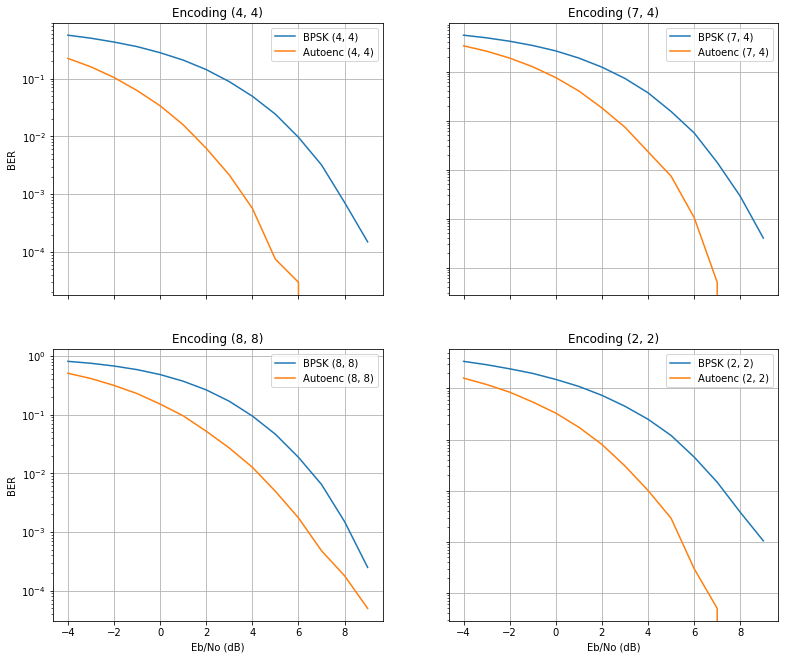

In [433]:
# Comparing each autoencoder with the theoritcal result
fig, axs = plt.subplots(2, 2, figsize=(13, 11), facecolor='w')

axs[0, 0].semilogy(snrs_db, results_y[0, 0,:])
axs[0, 0].semilogy(snrs_db, results_y[1, 0,:])
axs[0, 0].legend(('BPSK (4, 4)', 'Autoenc (4, 4)'))
axs[0, 0].set_title('Encoding (4, 4)')

axs[0, 1].semilogy(snrs_db, results_y[0, 1,:])
axs[0, 1].semilogy(snrs_db, results_y[1, 1,:])
axs[0, 1].legend(('BPSK (7, 4)', 'Autoenc (7, 4)'))
axs[0, 1].set_title('Encoding (7, 4)')

axs[1, 0].semilogy(snrs_db, results_y[0, 2,:])
axs[1, 0].semilogy(snrs_db, results_y[1, 2,:])
axs[1, 0].legend(('BPSK (8, 8)', 'Autoenc (8, 8)'))
axs[1, 0].set_title('Encoding (8, 8)')

axs[1, 1].semilogy(snrs_db, results_y[0, 3,:])
axs[1, 1].semilogy(snrs_db, results_y[1, 3,:])
axs[1, 1].legend(('BPSK (2, 2)', 'Autoenc (2, 2)'))
axs[1, 1].set_title('Encoding (2, 2)')

for ax in axs.flat:
    ax.grid(True)
    ax.set(xlabel='Eb/No (dB)', ylabel='BER')

for ax in axs.flat:
    ax.label_outer()

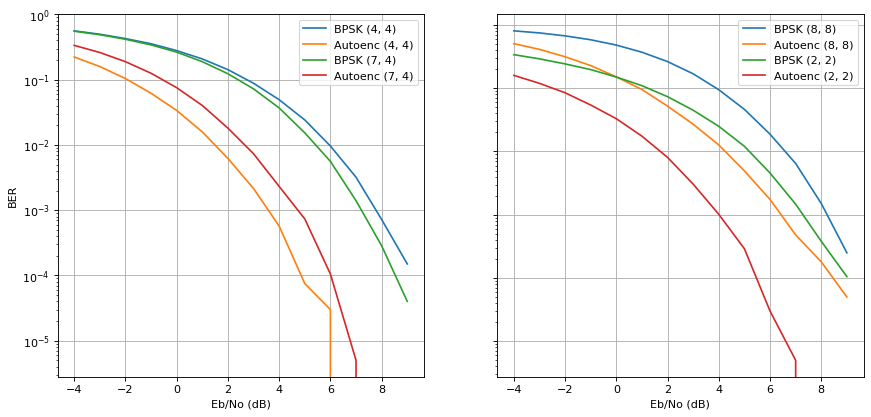

In [434]:
# Comparing each autoencoder with the theoritcal result
fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi= 80, facecolor='w')

axs[0].semilogy(snrs_db, results_y[0, 0,:])
axs[0].semilogy(snrs_db, results_y[1, 0,:])
axs[0].semilogy(snrs_db, results_y[0, 1,:])
axs[0].semilogy(snrs_db, results_y[1, 1,:])
axs[0].legend(('BPSK (4, 4)', 'Autoenc (4, 4)', 'BPSK (7, 4)', 'Autoenc (7, 4)'))

axs[1].semilogy(snrs_db, results_y[0, 2,:])
axs[1].semilogy(snrs_db, results_y[1, 2,:])
axs[1].semilogy(snrs_db, results_y[0, 3,:])
axs[1].semilogy(snrs_db, results_y[1, 3,:])
axs[1].legend(('BPSK (8, 8)', 'Autoenc (8, 8)', 'BPSK (2, 2)', 'Autoenc (2, 2)'))

for ax in axs.flat:
    ax.grid(True)
    ax.set(xlabel='Eb/No (dB)', ylabel='BER')

for ax in axs.flat:
    ax.label_outer()

### Useful links

- [Simulating BPSK with numpy](https://scipy-cookbook.readthedocs.io/items/CommTheory.html)
- [Installing scikit-dsp-comm](https://pypi.org/project/scikit-dsp-comm/)